In [2]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('../')
from dataset.PointCloudDataset import PointCloudDataset
from dataset.voxelDataset import VoxelDataset

# Visualization of pytorch architectures

## Pointnet

In [8]:
# in point net the unsqeeze is done in the network
import torchvision
from torchview import draw_graph
from networks.PointNet import PointNet
from dataset.PointCloudDataset import *

dataset_train  = PointCloudDataset('dataset/modelnet40_normal_resampled', 
                                            train=True, 
                                            ndata=1, 
                                            file_extension='.txt', 
                                            npoints=4000
                                        )

# torch tensor
data = dataset_train[0][0].unsqueeze(0)
print (data.shape)
model = PointNet(nclasses=40)

model_graph = draw_graph(model, input_size=data.shape, expand_nested=False, show_shapes=False, graph_dir='LR')
model_graph.visual_graph

Loaded 1 point clouds from 40 classes
torch.Size([1, 4000, 3])


In [9]:
model

PointNet(
  (conv1): Sequential(
    (conv1conv): Conv2d(1, 64, kernel_size=(1, 3), stride=(1, 1), padding=valid)
    (conv1batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_fn): ReLU()
  )
  (conv2): Sequential(
    (conv2conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv2batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_fn): ReLU()
  )
  (conv3): Sequential(
    (conv3conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv3batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_fn): ReLU()
  )
  (conv4): Sequential(
    (conv4conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (conv4batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_fn): ReLU()
  )
  (conv5): Sequential(
    (conv

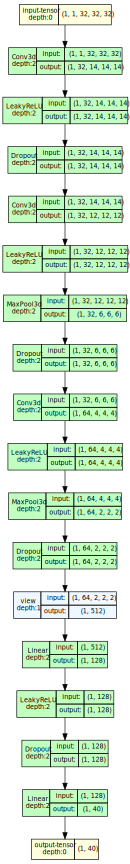

In [13]:
from networks.voxnet import VoxNet
model = VoxNet(nclasses=40, input_shape=(32,32,32))

model_graph = draw_graph(model, input_size=(1,1,32,32,32), expand_nested=False)
model_graph.visual_graph

# Visualization of meshes from the ModelNet40 dataset

In [3]:
paths = ['dataset/ModelNet40/flower_pot/test/flower_pot_0152.off',
        'dataset/ModelNet40/car/test/car_0265.off',
        'dataset/ModelNet40/guitar/test/guitar_0157.off',
        'dataset/ModelNet40/bottle/test/bottle_0336.off']


for path in paths:
    mesh = o3d.io.read_triangle_mesh(path)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([1, 0.706, 0])
    o3d.visualization.draw_geometries([mesh])


## Voxelization

show the same object with different voxelization resolutions

In [4]:
p = 'dataset/ModelNet40/flower_pot/test/flower_pot_0152.off'
mesh = o3d.io.read_triangle_mesh(p)

# set color
mesh.paint_uniform_color([1, 0.706, 0])

TriangleMesh with 6478 points and 4306 triangles.

In [ ]:

# voxelization
for vsize in [1,2,5]:
    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=vsize)
    # create voxel grid with new grid
    o3d.visualization.draw_geometries([voxel_grid])

# use open3d dataset to create the voxels

In [32]:
def get_voxel_grid(path='dataset/ModelNet40/flower_pot/test/flower_pot_0152.off', vsize=1):
    x = o3d.io.read_triangle_mesh(path)
    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(x, voxel_size=vsize)
    print ('')
    # create the  matrix with the voxel grid
    bounding_box = voxel_grid.get_axis_aligned_bounding_box()
    x, y, z = bounding_box.get_max_bound() - bounding_box.get_min_bound()
    grid = np.zeros((int(x/vsize), int(y/vsize), int(z/vsize)))
    # crop the voxel grid to the bounding box (32,32,50)
    #fill from the center with radial distance
    voxels = voxel_grid.get_voxels()
    voxels = [v.grid_index for v in voxels]
    voxels = np.array(voxels)

    # fill the grid
    for v in voxels:
        grid[v[0], v[1], v[2]] = 1

    # crop the grid to the input size, centered
    input_size = (32,32,32)
    x, y, z = grid.shape
    x0 = int((x - input_size[0])/2)
    y0 = int((y - input_size[1])/2)
    z0 = int((z - input_size[2])/2)

    voxel = grid[x0:x0+input_size[0], y0:y0+input_size[1], z0:z0+input_size[2]]
    return voxel


In [35]:
voxels = get_voxel_grid(vsize=1) 

In [7]:
# visualize the point cloud from file 
mesh = o3d.io.read_triangle_mesh('dataset/ModelNet40/flower_pot/test/flower_pot_0152.off')
# point cloud from mesh
pc = mesh.sample_points_uniformly(number_of_points=4000)
# change color to darkred   
pc.paint_uniform_color([0.9, 0, 0.1])


# plot pc with color darkred    
o3d.visualization.draw_geometries([pc]) 


: 

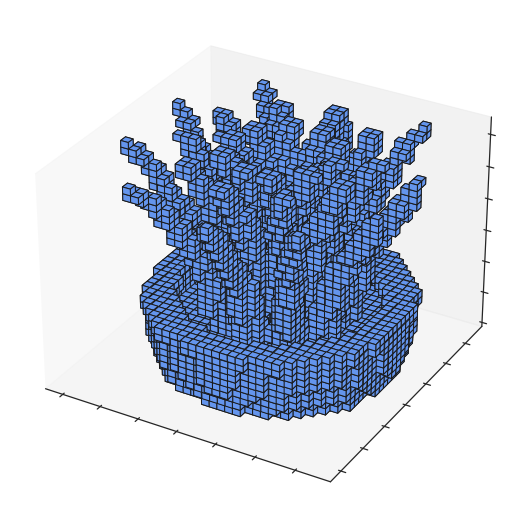

In [44]:
# plot in matplotlib
fig = plt.figure(figsize=(20,20))
sns.set_theme(style="white")
ax = fig.add_subplot(121, projection='3d')

ax.voxels(voxels, edgecolor='k', facecolor='cornflowerblue')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view = (20, 45)
# remove grid
ax.grid(False)

### create a dummy probability distirbution with countplot

Text(0, 0.5, 'Softmax')

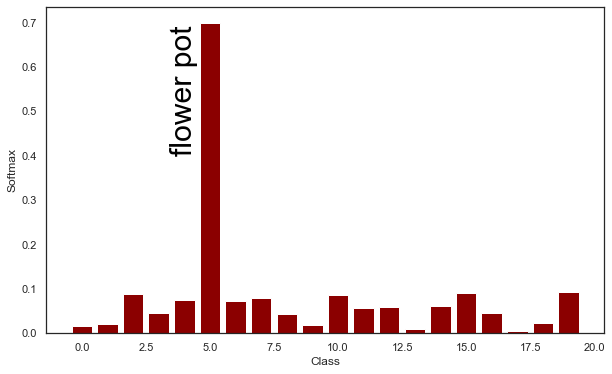

In [76]:
# cretae dummy softmax
N=20
softmax = np.random.rand(N)
softmax = softmax/np.sum(softmax)
# add one with the max value
softmax[5] = 0.7

# plot the softmax

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(np.arange(N), softmax, color='darkred')
# add text for the max value
ax.text(4, 0.4, 'flower pot', fontsize=30, color='black', ha='center', va='bottom', rotation=90)

ax.set_xlabel('Class')
ax.set_ylabel('Softmax')


# Training history and results

## Pointnet

In [23]:
# visualize the training history

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid", font_scale=1.5, palette = 'Dark2')


def plot_history(model_name):
    # load the data
    train_path = f'checkpoints/{model_name}/train_loss'
    val_path = f'checkpoints/{model_name}/val_loss'

    if os.path.exists(train_path+'.npy') and os.path.exists(val_path+'.npy'):
        train = np.load(train_path+'.npy')
        val = np.load(val_path+'.npy')
    else:
        train = np.loadtxt(train_path+'.txt')
        val = np.loadtxt(val_path+'.txt')
        

    epochs = np.arange(1, len(train)+1)
    lw = 2.5
    # plot the data
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(epochs, train, label='Training Loss', lw=lw)
    ax.plot(epochs, val, label='Validation Loss', lw=lw)

    ax.set_title(f'Training and Validation Loss for {model_name}')
    ax.set_xlabel('batch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    # save the figure in pdf
    fig.savefig(f'checkpoints/{model_name}/loss_{model_name}.pdf', bbox_inches='tight')

## Pointnet

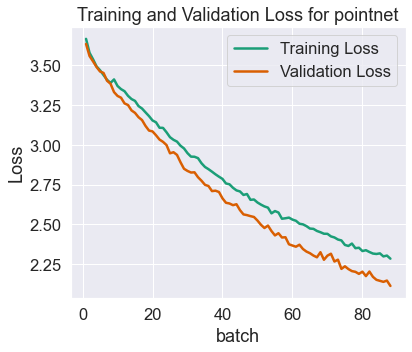

In [24]:
pnet = plot_history('pointnet')

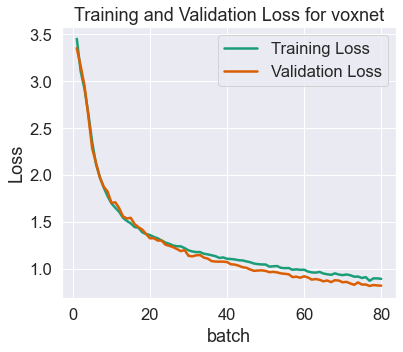

In [25]:
pnet = plot_history('voxnet')

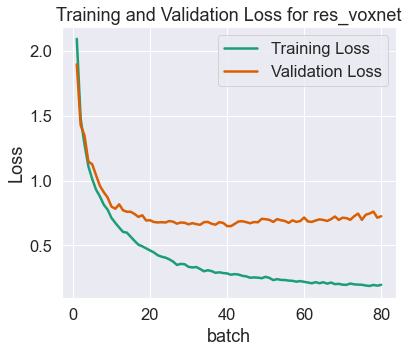

In [26]:
pnet = plot_history('res_voxnet')

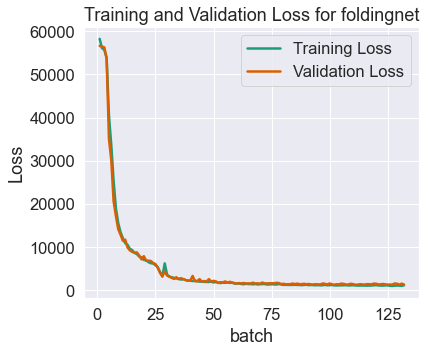

In [27]:
pnet = plot_history('foldingnet')